# The Transportation Simplex Method

<b>Information on group members:</b><br>
1) Sofya Aksenyuk <br>
2) Uladzimir Ivashka

In [1]:
from pulp import *  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Implementation

In [2]:
def check_results(costs, s, d):
    m, n = list(str(x) for x in range(len(costs))), list(str(x) for x in range(len(costs[0])))
    s_pulp = {str(x): s[x] for x in range(len(s))}
    d_pulp = {str(x): d[x] for x in range(len(d))}
    costs_pulp = {str(x): {str(y): costs[x][y] for y in range(len(n))} for x in range(len(m))}
    
    problem = LpProblem("Transportation Problem", LpMinimize)
    Routes = [(w, b) for w in m for b in n]
    route_vars = LpVariable.dicts("Route", (m, n), 0, None, LpInteger)
    problem += lpSum([route_vars[w][b]*costs_pulp[w][b] for (w,b) in Routes]), "Sum of Transporting Costs"
    
    for w in m:
        problem += lpSum([route_vars[w][b] for b in m]) <= s_pulp[w], "Sum of Products out of Warehouse %s"%w

    for b in n:
        problem += lpSum([route_vars[w][b] for w in n]) >= d_pulp[b], "Sum of Products into Bars %s"%b
    problem.solve(PULP_CBC_CMD(msg=False))

    return problem.objective.value()

In [3]:
def get_base(s, d):
    m = len(s)
    n = len(d)
    
    i, j = 0, 0
    base = []
    while len(base) < m + n - 1:
        value = min(s[i], d[j])
        s[i] -= value
        d[j] -= value
        base.append(((i, j), value))
        
        if s[i] == 0 and i < m - 1:
            i += 1
        elif d[j] == 0 and j < n - 1:
            j += 1
            
    return base

In [4]:
def get_non_basic(solution, costs, u, v):
    non_basic = []
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            if all([idx[0] != i or idx[1] != j for idx, _ in solution]):
                cur_value = cost - (u[i] + v[j])
                non_basic.append(((i, j), cur_value))
                
    return non_basic

In [5]:
def to_visit(chain, not_visited):
    row = []
    col = []
    for i in not_visited:
        if i[0] == chain[-1][0]:
            row.append(i)
        if i[1] == chain[-1][1]:
            col.append(i)
    
    if len(chain) == 1:
        return row + col
    else:
        if chain[-1][0] == chain[-2][0]: 
            return col
        else:
            return row

In [6]:
def invoke_chain(basic_var, chain, enter_var):
    if (enter_var[0] != chain[-1][0] and enter_var[1] == chain[-1][1])\
    or (enter_var[1] != chain[-1][1] and enter_var[0] == chain[-1][0])\
    and len(chain) == 1:
        return chain

    not_visited = list(set(basic_var) - set(chain))
    for cell in to_visit(chain, not_visited):
        new_chain = invoke_chain(basic_var, chain + [cell], enter_var)
        if new_chain != None: 
            return new_chain

In [7]:
def get_leaving_var(chain, base):
    leaving = []
    for cell in chain[1::2]:
        for idx, value in base:
            if idx == cell:
                leaving.append((idx, value))
                break
    leaving = sorted(leaving, key=lambda x: x[1])
    
    return leaving[0][0], leaving[0][1]

In [8]:
def get_most_assigned(temp_base):
    return np.argmax(np.bincount(np.array(list(dict(temp_base).keys()))[:, 0]))

In [9]:
def transportation(base, iter_counter):
    v = np.full(len(costs[0]), None)  ## m
    u = np.full(len(costs), None)     ## n
    
    temp_base = base.copy()
    u[get_most_assigned(temp_base)] = 0
    
    while len(temp_base) > 0:
        for idx, value in enumerate(temp_base):
            i, j = value[0]
            if u[i] == v[j] == None:
                continue
                
            if u[i] is None:
                u[i] = costs[i][j] - v[j]
            else: 
                v[j] = costs[i][j] - u[i]
            temp_base.pop(idx)
    non_basic = get_non_basic(base, costs, u, v)
    
    if any([value < 0 for _, value in non_basic]):
        
        enter_var = sorted(non_basic.copy(), key=lambda x: x[1])[0][0]
        chain = invoke_chain([idx for idx, _ in base], [enter_var], enter_var)
        leaving_var, leaving_value = get_leaving_var(chain, base)
        
        new_base = []
        options_for_base = dict(base)
        options_for_base.pop(leaving_var)
        options_for_base = list(options_for_base.items()) + [(chain[0], 0)]
        for idx, value in options_for_base:
            if idx in chain:
                if chain.index(idx) % 2 == 0:
                    value += leaving_value
                else:
                    value -= leaving_value
            new_base.append((idx, value))
            
        iter_counter += 1
        return transportation(new_base, iter_counter)

    return base, u, v, iter_counter

In [10]:
def get_solution(costs, s, d):
    base = get_base(s.copy(), d.copy())
    final_solution, u, v, iter_counter = transportation(base, 1)
    solution_matrix = np.zeros((len(costs), len(costs[0])))  ## m x n
    
    for (i, j), value in final_solution:
        solution_matrix[i][j] = value

    z = np.sum(np.array(costs) * np.array(solution_matrix))
    
    solution_matrix = np.concatenate((solution_matrix, [d], [v]), 0)
    
    df = pd.DataFrame(solution_matrix, index=list(range(1,solution_matrix.shape[0]-1))+['d', 'v'], 
                      columns=range(1,solution_matrix.shape[1]+1))
    
    df['s'] = np.concatenate((s, ['-'], ['-']))
    df['u'] = np.concatenate((u, ['-'], ['-']))

    return df, z, iter_counter

## Test Sample

In [11]:
M = 10000000000000000000000000000000000000000000  ## really large number as penalty

costs = np.array([
    [7, 5, 5, 0],
    [3, 10, 10, M],
    [3, 10, 10, 0],
    [M, M, 0, 0]
])

s = np.array([30, 20, 80, 80])
d = np.array([40, 40, 20, 110])

In [12]:
solution_matrix, z, iter_counter = get_solution(costs, s, d)
print(f'\nZ = {z}')
print("PulP Solution = ", check_results(costs, s, d))
print(f'Number of iterations: {iter_counter}')
solution_matrix


Z = 370.0
PulP Solution =  370.0
Number of iterations: 4


,1,2,3,4,s,u
1,0.0,30.0,0.0,0.0,30,-5
2,20.0,0.0,0.0,0.0,20,0
3,20.0,10.0,0.0,50.0,80,0
4,0.0,0.0,20.0,60.0,80,0
d,40,40,20,110,-,-
v,3,10,0,0,-,-


## Random Samples

In [13]:
def equal_sun_list(shape, mean):
    x = np.random.rand(shape)
    x *= mean / np.mean(x)
    y = np.random.rand(shape)
    mean_y = (np.sum(x)) / shape
    y *= mean / np.mean(y)
    
    return np.ceil(x), np.ceil(y)


Z = 625.0
PulP Solution =  625.0
Number of iterations: 5

Z = 934.0
PulP Solution =  934.0
Number of iterations: 4

Z = 783.0
PulP Solution =  783.0
Number of iterations: 4

Z = 1403.0
PulP Solution =  1403.0
Number of iterations: 6

Z = 1162.0
PulP Solution =  1162.0
Number of iterations: 9

Z = 1366.0
PulP Solution =  1366.0
Number of iterations: 9

Z = 1545.0
PulP Solution =  1545.0
Number of iterations: 9

Z = 896.0
PulP Solution =  896.0
Number of iterations: 10

Z = 2082.0
PulP Solution =  2082.0
Number of iterations: 5

Z = 1283.0
PulP Solution =  1283.0
Number of iterations: 7

Z = 757.0
PulP Solution =  757.0
Number of iterations: 19

Z = 1482.0
PulP Solution =  1482.0
Number of iterations: 20

Z = 896.0
PulP Solution =  896.0
Number of iterations: 18

Z = 1377.0
PulP Solution =  1377.0
Number of iterations: 20

Z = 1182.0
PulP Solution =  1182.0
Number of iterations: 23

Z = 1446.0
PulP Solution =  1446.0
Number of iterations: 21

Z = 2008.0
PulP Solution =  2008.0
Number of

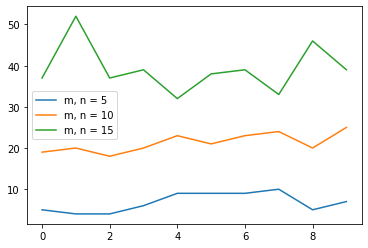

In [14]:
for shape in [5, 10, 15]:
    iter_stats = []
    
    for i in range(10):
        costs = (np.random.rand(shape, shape) * 10).astype(int)
        s, d = equal_sun_list(shape, 100)
        
        if sum(s) > sum(d):
            s[0] -= sum(s) - sum(d)
        if sum(s) < sum(d):
            d[0] -= sum(d) - sum(s) 
        solution_matrix, z, iter_counter = get_solution(costs, s, d)
        print(f'\nZ = {z}')
        print("PulP Solution = ", check_results(costs, s, d))
        print(f'Number of iterations: {iter_counter}')
        iter_stats.append(iter_counter)
        
    plt.plot(range(10), iter_stats, label=f"m, n = {shape}")
    plt.legend()